# Transformer model on JHMDB dataset

Change the project path to the appropriate project folder path

In [ ]:
 !pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path = 'drive/MyDrive/HumanActionRecognition/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp drive/MyDrive/HumanActionRecognition/Utils/tools/an_example_skeleton_of_standing.py .

In [ ]:
!cp drive/MyDrive/HumanActionRecognition/Utils/utils/lib_plot.py .

In [ ]:
!cp drive/MyDrive/HumanActionRecognition/Utils/utils/lib_commons.py .

In [ ]:
!pip install simplejson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import random
from random import randint
import time
import os
from scipy.spatial.distance import pdist
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import imageio
import os

In [ ]:
import cv2
import simplejson
from sklearn.preprocessing import OneHotEncoder
from an_example_skeleton_of_standing import get_a_normalized_jhmdb_skeleton
from collections import deque
import pickle
import sklearn.model_selection
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import lib_plot as lib_plot
import lib_commons as lib_commons
import math
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization


In [ ]:
def draw(skeleton): # helper function to draw skeleton
    x = skeleton[0::2]
    y = skeleton[1::2]
    plt.plot(x, y, "r*")
    plt.axis("equal")
    plt.show()


#Data augmentation:

1. Flips original data along x-axis
2. Adds Gaussian noise to original data with sigma 0.02
3. Adds Gaussian noise to original data with sigma 0.04
4. Rotates flipped data to 15°
5. Rotates flipped data to -15°
6. Rotates flipped data to 30°
7. Rotates flipped data to -30°

In [ ]:
def data_augment(x_df, y_df, size):
    #flipping
    x_copy = x_df.copy()
    x_copy[x_copy.columns[::2]] = x_copy[x_copy.columns[::2]].apply(lambda x: -x)
    x_flipped = pd.concat([x_df, x_copy], ignore_index=True)
    y_copy = y_df.copy()
    y_flipped = pd.concat([y_df, y_copy], ignore_index=True)
    #noising
    mu, sigma1 = 0, 0.02
    noise = np.random.normal(mu, sigma1, [size,34])
    x_noise = x_df + noise
    x_noised = pd.concat([x_flipped, x_noise], ignore_index=True)
    y_noised = pd.concat([y_flipped, y_copy], ignore_index=True)
    #noising2
    sigma2 = 0.04
    noise2 = np.random.normal(mu, sigma2, [size,34])
    x_noise2 = x_df + noise2
    x_noised2 = pd.concat([x_noised, x_noise2], ignore_index=True)
    y_noised2 = pd.concat([y_noised, y_copy], ignore_index=True)
    # rotate1
    x_rotate1 = x_flipped.apply(lambda x: rotate(x.to_numpy(), 15), axis=1, result_type='broadcast')
    x_rotated = pd.concat([x_noised2, x_rotate1], ignore_index=True)
    y_rotated = pd.concat([y_noised2, y_flipped], ignore_index=True)
    #rotate2
    x_rotate2 = x_flipped.apply(lambda x: rotate(x.to_numpy(), -15), axis=1, result_type='broadcast')
    x_rotated2 = pd.concat([x_rotated, x_rotate2], ignore_index=True)
    y_rotated2 = pd.concat([y_rotated, y_flipped], ignore_index=True)
    #rotate3
    x_rotate3 = x_flipped.apply(lambda x: rotate(x.to_numpy(), 30), axis=1, result_type='broadcast')
    x_rotated3 = pd.concat([x_rotated2, x_rotate3], ignore_index=True)
    y_rotated3 = pd.concat([y_rotated2, y_flipped], ignore_index=True)
    # rotate4
    x_rotate4 = x_flipped.apply(lambda x: rotate(x.to_numpy(), -30), axis=1, result_type='broadcast')
    x_rotated4 = pd.concat([x_rotated3, x_rotate4], ignore_index=True)
    y_rotated4 = pd.concat([y_rotated3, y_flipped], ignore_index=True)

    return x_rotated4, y_rotated4

In [ ]:
def rotate_joint(joint: tuple, p: int) -> tuple:
    x, y = joint
    psi = np.deg2rad(p)

    a = np.array([[np.cos(psi), -np.sin(psi)],
                  [np.sin(psi), np.cos(psi)]])
    b = np.array([x, y])
    joint = np.matmul(a, b)
    return joint

def rotate(frame, p: int) -> np.array:
    frame = frame.reshape(-1, 2)
    rotated = np.array([rotate_joint(joint=joint, p=p) for joint in frame])
    return rotated.reshape(-1)

# Feature extraction

In [ ]:
WINDOW_SIZE = int(5) # number of frames in action-snippet used to extract features.

In [ ]:
import numpy as np
CLASSES = np.array(['0', '1', '2', '3', '4', '5'])

In [ ]:
with open("/content/drive/MyDrive/HRNET/Train_cut", "rb") as fp:   # Unpickling
  train = pickle.load(fp)

with open("/content/drive/MyDrive/HRNET/Val_cut", "rb") as fp:   # Unpickling
  val = pickle.load(fp)

with open("/content/drive/MyDrive/HRNET/Test_cut", "rb") as fp:   # Unpickling
  test = pickle.load(fp)

In [ ]:
train = train + val
train_labels = train_labels + val_labels

In [ ]:
def zoom(p, target_l=32, joints_num=17, joints_dim=2):
    l = p.shape[0]
    p_new = np.empty([target_l, joints_num, joints_dim])
    for m in range(joints_num):
        for n in range(joints_dim):
            p[:, m, n] = medfilt(p[:, m, n], 3)
            p_new[:, m, n] = inter.zoom(p[:, m, n], target_l / l)[:target_l]
    return p_new


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import medfilt
import scipy.ndimage.interpolation as inter
# Example data

data = []
for video in train:
  video = zoom(video)
  data.append(video)



number_Of_videos = len(data)

# Reshape and concatenate the data for each frame of each video
frames = []
for i in range(number_Of_videos):
    for j in range(data[i].shape[0]):
        reshaped_data = data[i][j].reshape((1, 17*2))
        frames.append(pd.DataFrame(data=reshaped_data))

# Concatenate the data frames into a single DataFrame
df_train = pd.concat(frames, ignore_index=True)

# Create column names for the DataFrame
columns = [f'pos{i}_coord{j}' for i in range(17) for j in range(2)]
df_train.columns = columns

# Print the first 5 rows of the DataFrame
print(df_train.head())

<ipython-input-12-a5f4382baad1>:7: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:, m, n] = inter.zoom(p[:, m, n], target_l / l)[:target_l]


   pos0_coord0  pos0_coord1  pos1_coord0  pos1_coord1  pos2_coord0  \
0    68.623947    31.277958    69.414825    28.905361    68.623947   
1    68.616081    31.866560    69.393112    30.318384    68.616081   
2    69.239861    35.147247    70.094208    32.918533    69.239861   
3    70.962662    35.260166    72.524796    33.884529    70.962662   
4    70.179230    34.632328    71.357422    33.125015    70.179230   

   pos2_coord1  pos3_coord0  pos3_coord1  pos4_coord0  pos4_coord1  ...  \
0    28.905361    74.160019    28.905361    70.996552    28.114491  ...   
1    30.382627    74.179459    31.033491    74.249107    29.485142  ...   
2    33.619774    75.386406    32.029675    73.943153    31.475267  ...   
3    33.785522    77.592522    33.087261    74.576385    33.182766  ...   
4    33.152817    76.206680    32.983608    75.393326    32.696232  ...   

   pos12_coord0  pos12_coord1  pos13_coord0  pos13_coord1  pos14_coord0  \
0     74.950897     59.749187     78.766083     77.14

In [ ]:
train_videos = pickle.load(open("/content/drive/My Drive/KTH_Private/train.p", "rb"))
valid_videos = pickle.load(open("/content/drive/My Drive/KTH_Private/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/KTH_Private/test.p", "rb"))

In [ ]:

train_labels = []
for video in train_videos:
  train_labels.append(video['category'])
print(len(train_labels))
# train = train_poses


val_labels = []
for video in valid_videos:
  val_labels.append(video['category'])
print(len(val_labels))
# val = val_poses

test_labels = []
for video in test_videos:
  test_labels.append(video['category'])
print(len(test_labels))

191
192
216


In [ ]:
new_train_labels = []
for a in train_labels:
  if a == 'boxing':
    new_train_labels.append(0)
  elif a == 'handclapping':
    new_train_labels.append(1)
  elif a == 'handwaving':
    new_train_labels.append(2)
  elif a == 'jogging':
    new_train_labels.append(3)
  elif a == 'running':
    new_train_labels.append(4)
  else:
    new_train_labels.append(5)

print(new_train_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [ ]:
new_test_labels = []
for a in test_labels:
  if a == 'boxing':
    new_test_labels.append(0)
  elif a == 'handclapping':
    new_test_labels.append(1)
  elif a == 'handwaving':
    new_test_labels.append(2)
  elif a == 'jogging':
    new_test_labels.append(3)
  elif a == 'running':
    new_test_labels.append(4)
  else:
    new_test_labels.append(5)

print(new_test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [ ]:
train_labels = new_train_labels
test_labels = new_test_labels

In [ ]:
df_train_y = pd.DataFrame(train_labels)
df_train_y.head()

,0
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Example data
data = []
for video in test:
  video = zoom(video)
  data.append(video)


number_Of_videos = len(data)

# Reshape and concatenate the data for each frame of each video
frames = []
for i in range(number_Of_videos):
    for j in range(data[i].shape[0]):
        reshaped_data = data[i][j].reshape((1, 17*2))
        frames.append(pd.DataFrame(data=reshaped_data))

# Concatenate the data frames into a single DataFrame
df_test = pd.concat(frames, ignore_index=True)

# Create column names for the DataFrame
columns = [f'pos{i}_coord{j}' for i in range(17) for j in range(2)]
df_test.columns = columns

# Print the first 5 rows of the DataFrame
print(df_test.head())


df_test_y = pd.DataFrame(test_labels)


<ipython-input-12-a5f4382baad1>:7: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  p_new[:, m, n] = inter.zoom(p[:, m, n], target_l / l)[:target_l]


   pos0_coord0  pos0_coord1  pos1_coord0  pos1_coord1  pos2_coord0  \
0    74.373444    16.991039    75.350090    16.014393    74.373444   
1    75.301651    16.795254    77.452248    15.889418    75.696960   
2    76.670456    18.975433    77.775055    17.301794    76.982780   
3    77.614990    20.613356    79.577797    18.709284    77.614594   
4    78.542778    18.145918    80.453812    16.625309    78.960655   

   pos2_coord1  pos3_coord0  pos3_coord1  pos4_coord0  pos4_coord1  ...  \
0    16.014393    80.233337    17.967686    82.186630    16.991039  ...   
1    15.889311    82.080101    17.935841    82.462234    16.958937  ...   
2    17.302341    82.100166    18.418417    83.019310    17.451359  ...   
3    18.710180    84.402626    20.658073    84.610764    19.695131  ...   
4    16.600689    84.800339    18.418045    84.332352    17.864376  ...   

   pos12_coord0  pos12_coord1  pos13_coord0  pos13_coord1  pos14_coord0  \
0     83.750763     54.103687     85.116577     79.49

In [ ]:
print(len(train_labels))

383


In [ ]:
LABELS = ['boxing' 'handclapping', 'handwaving', 'jogging', 'running', 'walking']

In [ ]:
class Math():
    ''' Some math operations '''
    @staticmethod
    def calc_dist(p1, p0):
        return math.sqrt((p1[0]-p0[0])**2+(p1[1]-p0[1])**2)

    @staticmethod
    def pi2pi(x):
        if x > PI:
            x -= 2*PI
        if x <= -PI:
            x += 2*PI
        return x

    @staticmethod
    def calc_relative_angle(x1, y1, x0, y0, base_angle):
        # compute rotation from {base_angle} to {(x0,y0)->(x1,y1)}
        if (y1 == y0) and (x1 == x0):
            return 0
        a1 = np.arctan2(y1-y0, x1-x0)
        return Math.pi2pi(a1 - base_angle)

    @staticmethod
    def calc_relative_angle_v2(p1, p0, base_angle):
        # compute rotation from {base_angle} to {p0->p1}
        return Math.calc_relative_angle(p1[0], p1[1], p0[0], p0[1], base_angle)

In [ ]:
# -- Functions for processing features
def get_joint(x, idx):
    px = x[2*idx]
    py = x[2*idx+1]
    return px, py

def set_joint(x, idx, px, py):
    x[2*idx] = px
    x[2*idx+1] = py
    return

def check_joint(x, idx):
    return x[2*idx] != NaN

class ProcFtr(object):

    @staticmethod
    def drop_arms_and_legs_randomly(x, thresh=0.3):
        ''' Randomly drop one arm or one leg with a probability of thresh '''
        x = x.copy()
        N = len(ARMS_LEGS)
        rand_num = np.random.random()
        if rand_num < thresh:
            joint_idx = int((rand_num / thresh)*N)
            set_joint(x, joint_idx, NaN, NaN)
        return x

    @staticmethod
    def has_neck_and_thigh(x):
        ''' Check if a skeleton has a neck and at least one thigh '''
        return check_joint(x, NECK) and (check_joint(x, L_THIGH) or check_joint(x, R_THIGH))

    @staticmethod
    def get_body_height(x):
        ''' Compute height of the body, which is defined as:
            the distance between `neck` and `thigh`.
        '''
        x0, y0 = get_joint(x, NECK)

        # Get average thigh height
        x11, y11 = get_joint(x, L_THIGH)
        x12, y12 = get_joint(x, R_THIGH)
        if y11 == NaN and y12 == NaN:  # Invalid data
            return 1.0
        if y11 == NaN:
            x1, y1 = x12, y12
        elif y12 == NaN:
            x1, y1 = x11, y11
        else:
            x1, y1 = (x11 + x12) / 2, (y11 + y12) / 2

        # Get body height
        height = ((x0-x1)**2 + (y0-y1)**2)**(0.5)
        return height

    @staticmethod
    def remove_body_offset(x):
        ''' The origin is the neck.
        TODO: Deal with empty data.
        '''
        x = x.copy()
        px0, py0 = get_joint(x, NECK)
        x[0::2] = x[0::2] - px0
        x[1::2] = x[1::2] - py0
        return x

    @staticmethod
    def joint_pos_2_angle_and_length(x):
        ''' Change the representation of skeletons
            From xy positions to angle and length.
        '''
        # ---------------------- Get joint positions ----------------------
        class JointPosExtractor(object):
            def __init__(self, x):
                self.x = x
                self.i = 0

            def get_next_point(self):
                p = [self.x[self.i], self.x[self.i+1]]
                self.i += 2
                return p
        tmp = JointPosExtractor(x)

        pneck = tmp.get_next_point()

        prshoulder = tmp.get_next_point()
        prelbow = tmp.get_next_point()
        prwrist = tmp.get_next_point()

        plshoulder = tmp.get_next_point()
        plelbow = tmp.get_next_point()
        plwrist = tmp.get_next_point()

        prhip = tmp.get_next_point()
        prknee = tmp.get_next_point()
        prankle = tmp.get_next_point()

        plhip = tmp.get_next_point()
        plknee = tmp.get_next_point()
        plankle = tmp.get_next_point()

        # ---------------------- Get joint angels ----------------------
        class Get12Angles(object):
            def __init__(self):
                self.j = 0
                self.f_angles = np.zeros((12,))
                self.x_lengths = np.zeros((12,))

            def set_next_angle_len(self, next_joint, base_joint, base_angle):
                angle = Math.calc_relative_angle_v2(
                    next_joint, base_joint, base_angle)
                dist = Math.calc_dist(next_joint, base_joint)
                self.f_angles[self.j] = angle
                self.x_lengths[self.j] = dist
                self.j += 1

        tmp2 = Get12Angles()
        tmp2.set_next_angle_len(prshoulder, pneck, PI)  # r-shoulder
        tmp2.set_next_angle_len(prelbow, prshoulder, PI/2)  # r-elbow
        tmp2.set_next_angle_len(prwrist, prelbow, PI/2)  # r-wrist

        tmp2.set_next_angle_len(plshoulder, pneck, 0)  # l-shoulder
        tmp2.set_next_angle_len(plelbow, plshoulder, PI/2)  # l-elbow
        tmp2.set_next_angle_len(plwrist, plelbow, PI/2)  # l-wrist

        tmp2.set_next_angle_len(prhip, pneck, PI/2+PI/18)
        tmp2.set_next_angle_len(prknee, prhip, PI/2)
        tmp2.set_next_angle_len(prankle, prknee, PI/2)

        tmp2.set_next_angle_len(plhip, pneck, PI/2-PI/18)
        tmp2.set_next_angle_len(plknee, plhip, PI/2)
        tmp2.set_next_angle_len(plankle, plknee, PI/2)

        # Output
        features_angles = tmp2.f_angles
        features_lens = tmp2.x_lengths
        return features_angles, features_lens

Feature generator class:
1. Fills missing data with its relative position in previous frame
2. Generates normalized skeleton joints feature
3. Computes velocity of center feature
4. Computes velocity of joints feature
5. Computes euclidean distance of pairs of joints

In [ ]:
# -- The main class for extracting features
class FeatureGenerator(object):
    def __init__(self,
                 window_size,
                 is_adding_noise=False):
        '''
        Arguments:
            window_size {int}: Number of adjacent frames for extracting features.
            is_adding_noise {bool}: Is adding noise to the joint positions and scale.
            noise_intensity {float}: The noise relative to the body height.
        '''
        self._window_size = window_size
        self._is_adding_noise = is_adding_noise
        self._noise_intensity = NOISE_INTENSITY
        self.reset()

    def reset(self):
        ''' Reset the FeatureGenerator '''
        self._x_deque = deque()
        self._angles_deque = deque()
        self._lens_deque = deque()
        self._pre_x = None

    def add_cur_skeleton(self, skeleton):
        ''' Input a new skeleton, return the extracted feature.
        Returns:
            is_success {bool}: Return the feature only when
                the historical input skeletons are more than self._window_size.
            features {np.array}
        '''
        x = retrain_only_body_joints(skeleton)


#         if not ProcFtr.has_neck_and_thigh(x):
#             self.reset()
#             print('False', x)
#             return False, None
#         else:
        ''' The input skeleton has a neck and at least one thigh '''
            # -- Preprocess x
            # Fill zeros, compute angles/lens
        # x = self._fill_invalid_data(x)
        if self._is_adding_noise:
                # Add noise druing training stage to augment data
            x = self._add_noises(x, self._noise_intensity)
        x = np.array(x)
        # angles, lens = ProcFtr.joint_pos_2_angle_and_length(x) # deprecate

            # Push to deque
        self._x_deque.append(x)
        # self._angles_deque.append(angles) # deprecate
        # self._lens_deque.append(lens) # deprecate

        self._maintain_deque_size()
        self._pre_x = x.copy()

            # -- Extract features
        if len(self._x_deque) < self._window_size:
            return False, None, None

        else:
                # -- Normalize all 1~t features
            h_list = [ProcFtr.get_body_height(xi) for xi in self._x_deque]
            mean_height = np.mean(h_list)
            xnorm_list = [ProcFtr.remove_body_offset(xi)/mean_height
                            for xi in self._x_deque]

                # -- Get features of pose/angles/lens
            f_poses = self._deque_features_to_1darray(xnorm_list)
            # f_angles = self._deque_features_to_1darray(self._angles_deque) # deprecate
            # f_lens = self._deque_features_to_1darray(
            #         self._lens_deque) / mean_height # deprecate

                #  Get features of motion

            f_v_center = self._compute_v_center(
                self._x_deque, step=1) / mean_height  # len = (t=4)*2 = 8
            f_v_center = np.repeat(f_v_center, 10)  # repeat to add weight

            f_v_joints = self._compute_v_all_joints(
                xnorm_list, step=1)  # len = (t=(5-1)/step)*12*2 = 96
            f_d_joints = self._compute_distance(xnorm_list)

                # -- Output
            features = np.concatenate((f_poses, f_v_joints, f_v_center))

            distance = f_d_joints
            return True, features.copy(), distance.copy()

    def _maintain_deque_size(self):
        if len(self._x_deque) > self._window_size:
            self._x_deque.popleft()
        if len(self._angles_deque) > self._window_size:
            self._angles_deque.popleft()
        if len(self._lens_deque) > self._window_size:
            self._lens_deque.popleft()

    def _compute_v_center(self, x_deque, step):
        vel = []
        for i in range(0, len(x_deque) - step, step):
            dxdy = x_deque[i+step][0:2] - x_deque[i][0:2]
            vel += dxdy.tolist()
        return np.array(vel)

    def _compute_v_all_joints(self, xnorm_list, step):
        vel = []
        for i in range(0, len(xnorm_list) - step, step):
            dxdy = xnorm_list[i+step][:] - xnorm_list[i][:]
            vel += dxdy.tolist()
        return np.array(vel)

    def _compute_distance(self, xnorm_list):
        dist = []
        for i in range(0, len(xnorm_list)):
            x = np.reshape(xnorm_list[i], (17, 2))
            dist_arr = pdist(x)
            dist+= dist_arr.tolist()
        #print('dist', len(dist))
        return np.array(dist)

    def _fill_invalid_data(self, x):
        ''' Fill the NaN elements in x with
            their relative-to-neck position in the preious x.
        Argument:
            x {np.array}: a skeleton that has a neck and at least a thigh.
        '''
        res = x.copy()

        def get_px_py_px0_py0(x):
            px = x[0::2]  # list of x
            py = x[1::2]  # list of y
            px0, py0 = get_joint(x, NECK)  # neck
            return px, py, px0, py0
        cur_px, cur_py, cur_px0, cur_py0 = get_px_py_px0_py0(x)
        cur_height = ProcFtr.get_body_height(x)

        is_lack_knee = check_joint(x, L_KNEE) or check_joint(x, R_KNEE)
        is_lack_ankle = check_joint(x, L_ANKLE) or check_joint(x, R_ANKLE)
        if (self._pre_x is None) or is_lack_knee or is_lack_ankle:
            # If preious data is invalid or there is no knee or ankle,
            # then fill the data based on the STAND_SKEL_NORMED.
            for i in range(TOTAL_JOINTS*2):
                if res[i] == NaN:
                    res[i] = (cur_px0 if i % 2 == 0 else cur_py0) + \
                        cur_height * STAND_SKEL_NORMED[i]
            return res

        pre_px, pre_py, pre_px0, pre_py0 = get_px_py_px0_py0(self._pre_x)
        pre_height = ProcFtr.get_body_height(self._pre_x)

        scale = cur_height / pre_height

        bad_idxs = np.nonzero(cur_px == NaN)[0]
        if not len(bad_idxs):  # No invalid data
            return res

        cur_px[bad_idxs] = cur_px0 + (pre_px[bad_idxs] - pre_px0) * scale
        cur_py[bad_idxs] = cur_py0 + (pre_py[bad_idxs] - pre_py0) * scale
        res[::2] = cur_px
        res[1::2] = cur_py
        return res


    def _add_noises(self, x, intensity):
        ''' Add noise to x with a ratio relative to the body height '''
        height = ProcFtr.get_body_height(x)
        randoms = (np.random.random(x.shape, ) - 0.5) * 2 * intensity * height
        x = [(xi + randoms[i] if xi != 0 else xi)
             for i, xi in enumerate(x)]
        return x

    def _deque_features_to_1darray(self, deque_data):
        features = []
        for i in range(len(deque_data)):
            next_feature = deque_data[i].tolist()
            features += next_feature
        features = np.array(features)
        return features

    def _deque_features_to_2darray(self, deque_data):
        features = []
        for i in range(len(deque_data)):
            next_feature = deque_data[i].tolist()
            features.append(next_feature)
        features = np.array(features)
        return features

Positions of skeleton joints

In [ ]:
# -- Settings
NOISE_INTENSITY = 0.05
# -- Constant
PI = np.pi
Inf = float("inf")
NaN = 0.0

def retrain_only_body_joints(skeleton):
    ''' All skeleton operations in this script are done after this function.
    '''
    return skeleton.copy()

TOTAL_JOINTS = 17
NECK = 0
Belly = 1
HEAD = 2
L_ARMS = [3, 7, 11]
R_ARMS = [4, 8, 12]
L_KNEE = 9
L_ANKLE = 13
R_KNEE = 10
R_ANKLE = 14
L_LEGS = [9, 13]
R_LEGS = [10, 14]
ARMS_LEGS = L_ARMS + R_ARMS + L_LEGS + R_LEGS
L_THIGH = 5
R_THIGH = 6

# STAND_SKEL_NORMED = retrain_only_body_joints(
#     get_a_normalized_jhmdb_skeleton())

In [ ]:
def process_features(X0, Y0, video_indices, classes):
    ''' Process features '''
    # Convert features
    # From: raw feature of individual image.
    # To:   time-serials features calculated from multiple raw features
    #       of multiple adjacent images, including velocity, normalized pos, etc.
    ADD_NOISE = False
    if ADD_NOISE:
        X1, Y1, X_distance1= extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE,
            is_adding_noise=True, is_print=True)
        X2, Y2, X_distance2 = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE,
            is_adding_noise=False, is_print=True)
        X = np.vstack((X1, X2))
        Y = np.concatenate((Y1, Y2))
        X_distance = np.vstack((X_distance1, X_distance2))
        return X, Y, X_distance
    else:
        X, Y, X_distance = extract_multi_frame_features(
            X0, Y0, video_indices, WINDOW_SIZE,
            is_adding_noise=False, is_print=True)
        return X, Y, X_distance
# -- Functions
def extract_multi_frame_features(
        X, Y, video_indices, window_size,
        is_adding_noise=False, is_print=False):
    ''' From image index and raw skeleton positions,
        Extract features of body velocity, joint velocity, and normalized joint positions, distance feature.
    '''
    X_new = []
    Y_new = []
    N = len(video_indices)
    X_distance = []

    # Loop through all data

    for i, _ in enumerate(video_indices):

        # If a new video clip starts, reset the feature generator
        if i == 0 or video_indices[i] != video_indices[i-1]:
            fg = FeatureGenerator(window_size, is_adding_noise)

        # Get features
        success, features, distance = fg.add_cur_skeleton(X[i, :])
        if success:  # True if (data length > 5) and (skeleton has enough joints)
            X_new.append(features)
            Y_new.append(Y[i])
            X_distance.append(distance)

        # Print
        if is_print and i % 1000 == 0:
            print(f"{i}/{N}", end=", ")

    if is_print:
        print("")
    X_new = np.array(X_new)
    Y_new = np.array(Y_new)
    X_distance = np.array(X_distance)
    return X_new, Y_new, X_distance



# Data loading

JHMDB data has three splits and each of them splited into train and test set. Each set contains skeleton dataset and labels dataset.

Skeleton data in csv format and each row contains skeleton joint coordinates of one frame.

Dataset of labels contains action labels of each video.

# Split 1

In [ ]:
train = train+val

In [ ]:
x_1 = pd.read_csv(path+'jhmdb/data/GT_train_1.csv', header=None)
y_1 = pd.read_csv(path+'jhmdb/data/GT_train_y_1.csv', header=None)

In [ ]:
df_train.tail()

,pos0_coord0,pos0_coord1,pos1_coord0,pos1_coord1,pos2_coord0,pos2_coord1,pos3_coord0,pos3_coord1,pos4_coord0,pos4_coord1,...,pos12_coord0,pos12_coord1,pos13_coord0,pos13_coord1,pos14_coord0,pos14_coord1,pos15_coord0,pos15_coord1,pos16_coord0,pos16_coord1
12251,7.972752e+01,2.087219e+01,8.115162e+01,1.885813e+01,7.955486e+01,1.842806e+01,8.562742e+01,1.976403e+01,8.506591e+01,1.972895e+01,...,8.448196e+01,5.643328e+01,8.320457e+01,7.709518e+01,8.186618e+01,7.673421e+01,9.119815e+01,9.810874e+01,7.649194e+01,9.602219e+01
12252,4.755157e+01,1.904038e+01,4.854809e+01,1.710625e+01,4.761420e+01,1.711948e+01,5.322559e+01,1.803232e+01,5.415541e+01,1.807898e+01,...,5.320715e+01,5.524762e+01,4.678114e+01,7.581015e+01,5.184503e+01,7.518527e+01,4.658672e+01,9.686801e+01,7.012853e+01,9.240217e+01
12253,2.053607e+01,1.799463e+01,2.162393e+01,1.614981e+01,2.208127e+01,1.615791e+01,2.617193e+01,1.681679e+01,2.581013e+01,1.613171e+01,...,2.671605e+01,5.432300e+01,2.734100e+01,7.328592e+01,2.276542e+01,7.321486e+01,3.841174e+01,9.451688e+01,1.602985e+01,9.099008e+01
12254,3.560375e+00,1.940143e+01,3.182804e+00,1.729771e+01,1.039131e+01,1.729614e+01,4.990436e+00,1.720915e+01,1.562046e+01,1.656009e+01,...,1.252169e+01,6.084499e+01,4.000054e+00,8.148968e+01,9.611897e+00,8.376816e+01,1.276031e+01,9.944879e+01,1.665784e+01,9.956637e+01
12255,5.736647e-16,1.408891e-15,4.898189e-16,1.277134e-15,1.026788e-15,1.276487e-15,9.095949e-16,3.018009e-15,7.145167e-16,1.323438e-15,...,1.975458e-15,7.686960e-15,-3.649554e-16,1.231211e-14,1.443584e-15,1.261649e-14,1.159146e-15,6.935159e-15,1.821933e-15,1.409876e-14


In [ ]:
train_labels = train_labels + val_labels

In [ ]:
df_train_y = pd.DataFrame(train_labels)
df_train_y.head()

,0
0,0
1,0
2,0
3,0
4,0


In [ ]:
df_train_y.tail()

,0
186,5
187,5
188,5
189,5
190,5


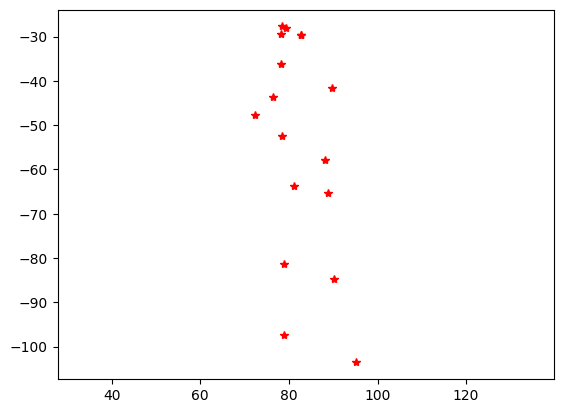

In [ ]:
df_train[df_train.columns[1::2]] = df_train[df_train.columns[1::2]].apply(lambda y: -y)
draw(df_train.iloc[156])

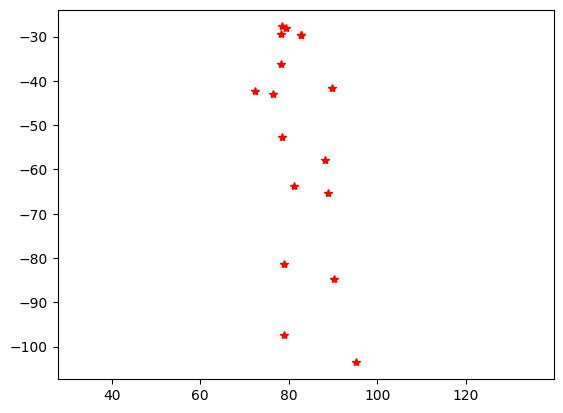

In [ ]:
draw(df_train.iloc[156])

In [ ]:
df_train.iloc[156]

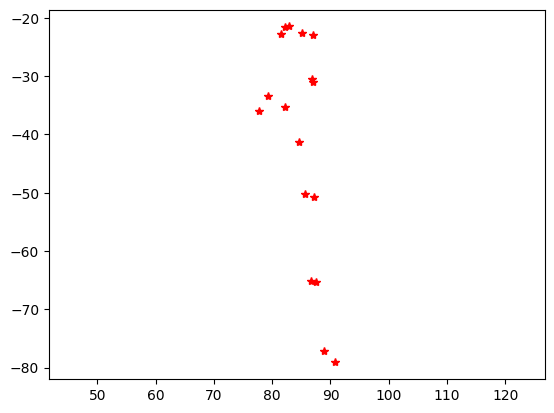

In [ ]:
df_test[df_test.columns[1::2]] = df_test[df_test.columns[1::2]].apply(lambda y: -y)
draw(df_test.iloc[155])

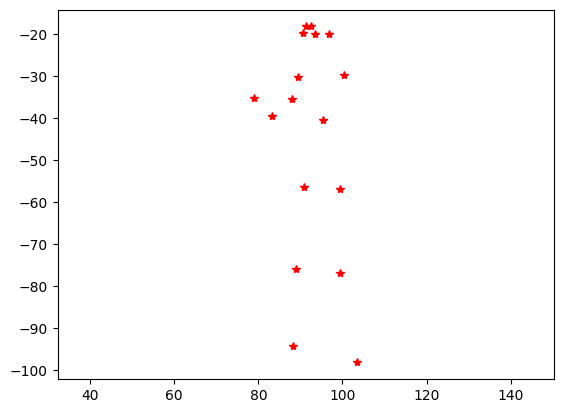

In [ ]:
draw(df_test.iloc[500])

In [ ]:
df_test_y.head()

,0
0,0
1,0
2,0
3,0
4,0


Augmenting data

In [ ]:
x_aug, y_aug = data_augment(df_train, df_train_y, 7555)

In [ ]:
x_train_arr1 =  df_train.to_numpy()
y_train_arr1 = df_train_y.to_numpy()

In [ ]:
x_train_arr1 =  x_aug.to_numpy()
y_train_arr1 = y_aug.to_numpy()

In [ ]:
df_test_y

,0
0,0
1,0
2,0
3,0
4,0
...,...
211,5
212,5
213,5
214,5


Action labels are repeated for each frame in order to generate features correctly

In [ ]:
len(train[4])

59

In [ ]:
y_train1 = []
video_indices1 = []
for i in range(len(y_train_arr1)):
    y_train1.extend([y_train_arr1[i][0]]*32)
    video_indices1.extend([i]*32)

In [ ]:
print('x_test_arr', x_train_arr1.shape)
print('y_test_arr', y_train_arr1.shape)

x_test_arr (12256, 34)
y_test_arr (383, 1)


In [ ]:
x_1_test = pd.read_csv(path+'jhmdb/data/GT_test_1.csv', header=None)
y_1_test = pd.read_csv(path+'jhmdb/data/GT_test_y_1.csv', header=None)

In [ ]:
x_test_arr1 =  df_test.to_numpy()
y_test_arr1 = df_test_y.to_numpy()

In [ ]:
y_test1 = []
video_indices_test1 = []
for i in range(len(y_test_arr1)):
    y_test1.extend([y_test_arr1[i][0]]*32)
    video_indices_test1.extend([i]*32)

Extracting features for train set

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
X_train1, y_tr, X_train_d1= process_features(x_train_arr1, y_train1, video_indices1, CLASSES)
print(f"X.shape = {X_train1.shape}, len(Y) = {len(y_tr)}")


Extracting time-serials features ...
0/12256, 1000/12256, 2000/12256, 3000/12256, 4000/12256, 5000/12256, 6000/12256, 7000/12256, 8000/12256, 9000/12256, 10000/12256, 11000/12256, 12000/12256, 
X.shape = (10724, 386), len(Y) = 10724


Extracting features for test set

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
time_start = time.time()
X_test1, y_te, X_test_d1 = process_features(x_test_arr1, y_test1, video_indices_test1, CLASSES)
time_stop = time.time()
print(f"X.shape = {X_test1.shape}, len(Y) = {len(y_te)}")
print("TOTAL TIME:  {}".format(time_stop - time_start))


Extracting time-serials features ...
0/6912, 1000/6912, 2000/6912, 3000/6912, 4000/6912, 5000/6912, 6000/6912, 
X.shape = (6048, 386), len(Y) = 6048
TOTAL TIME:  1.414724588394165


In [ ]:
y_tr

array([0, 0, 0, ..., 5, 5, 5])

## PCA for joint based features

Joint based features reduced to 100 dimension

In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 100

n_components = min(NUM_FEATURES_FROM_PCA, X_train1.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train1)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr1 = pca.transform(X_train1)
print("After PCA, X.shape = ", X_tr1.shape)

Sum eig values: 0.9990515211136957
After PCA, X.shape =  (10724, 100)


In [ ]:
time_start = time.time()
X_te1 = pca.transform(X_test1)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.02774810791015625


## PCA for distance feature

Distance feature dimension reduced to 50

In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 50

n_components = min(NUM_FEATURES_FROM_PCA, X_train_d1.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_d1)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr_d1 = pca.transform(X_train_d1)
print("After PCA, X.shape = ", X_tr_d1.shape)

Sum eig values: 0.9901507563556682
After PCA, X.shape =  (10724, 50)


In [ ]:
time_start = time.time()
X_te_d1 = pca.transform(X_test_d1)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.03177285194396973


Concatenate Joint based and Distance based features

In [ ]:
X_train1 = np.concatenate((X_tr1, X_tr_d1), axis=1)
X_train1.shape

(10724, 150)

In [ ]:
X_test1 = np.concatenate((X_te1, X_te_d1), axis=1)
X_test1.shape

(6048, 150)

In [ ]:
blocks = int(len(X_train1) / 28)
X_train1 = np.array(np.split(X_train1, blocks))
X_train1.shape

(383, 28, 150)

In [ ]:
blocks = int(len(X_test1) / 28)
X_test1 = np.array(np.split(X_test1, blocks))
X_test1.shape

(216, 28, 150)

# Split 2

In [ ]:
x_2 = pd.read_csv(path+'jhmdb/data/GT_train_2.csv', header=None)
y_2 = pd.read_csv(path+'jhmdb/data/GT_train_y_2.csv', header=None)

In [ ]:
x_2.shape

(21056, 30)

In [ ]:
x_2[x_2.columns[1::2]] = x_2[x_2.columns[1::2]].apply(lambda y: -y)

In [ ]:
x_aug2, y_aug2 = data_augment(x_2, y_2, 21056)

In [ ]:
x_train_arr2 =  x_aug2.to_numpy()
y_train_arr2 = y_aug2.to_numpy()

In [ ]:
y_train2 = []
video_indices2 = []
for i in range(len(y_train_arr2)):
    y_train2.extend([y_train_arr2[i][0]]*32)
    video_indices2.extend([i]*32)

In [ ]:
print('x_test_arr', x_train_arr2.shape)
print('y_test_arr', y_train_arr2.shape)

x_test_arr (252672, 30)
y_test_arr (7896, 1)


In [ ]:
x_2_test = pd.read_csv(path+'jhmdb/data/GT_test_2.csv', header=None)
y_2_test = pd.read_csv(path+'jhmdb/data/GT_test_y_2.csv', header=None)

In [ ]:
x_2_test[x_2_test.columns[1::2]] = x_2_test[x_2_test.columns[1::2]].apply(lambda y: -y)

In [ ]:
x_test_arr2 =  x_2_test.to_numpy()
y_test_arr2 = y_2_test.to_numpy()

In [ ]:
y_test2 = []
video_indices_test2 = []
for i in range(len(y_test_arr2)):
    y_test2.extend([y_test_arr2[i][0]]*32)
    video_indices_test2.extend([i]*32)

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
X_train2, y_tr, X_train_d2= process_features(x_train_arr2, y_train2, video_indices2, CLASSES)
print(f"X.shape = {X_train2.shape}, len(Y) = {len(y_tr)}")



Extracting time-serials features ...
0/252672, 1000/252672, 2000/252672, 3000/252672, 4000/252672, 5000/252672, 6000/252672, 7000/252672, 8000/252672, 9000/252672, 10000/252672, 11000/252672, 12000/252672, 13000/252672, 14000/252672, 15000/252672, 16000/252672, 17000/252672, 18000/252672, 19000/252672, 20000/252672, 21000/252672, 22000/252672, 23000/252672, 24000/252672, 25000/252672, 26000/252672, 27000/252672, 28000/252672, 29000/252672, 30000/252672, 31000/252672, 32000/252672, 33000/252672, 34000/252672, 35000/252672, 36000/252672, 37000/252672, 38000/252672, 39000/252672, 40000/252672, 41000/252672, 42000/252672, 43000/252672, 44000/252672, 45000/252672, 46000/252672, 47000/252672, 48000/252672, 49000/252672, 50000/252672, 51000/252672, 52000/252672, 53000/252672, 54000/252672, 55000/252672, 56000/252672, 57000/252672, 58000/252672, 59000/252672, 60000/252672, 61000/252672, 62000/252672, 63000/252672, 64000/252672, 65000/252672, 66000/252672, 67000/252672, 68000/252672, 69000/252

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
time_start = time.time()
X_test2, y_te, X_test_d2 = process_features(x_test_arr2, y_test2, video_indices_test2, CLASSES)
time_stop = time.time()
print(f"X.shape = {X_test2.shape}, len(Y) = {len(y_te)}")
print("TOTAL TIME:  {}".format(time_stop - time_start))



Extracting time-serials features ...
0/8640, 1000/8640, 2000/8640, 3000/8640, 4000/8640, 5000/8640, 6000/8640, 7000/8640, 8000/8640, 
X.shape = (7560, 350), len(Y) = 7560
TOTAL TIME:  1.8711984157562256


In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 100

n_components = min(NUM_FEATURES_FROM_PCA, X_train2.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train2)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr2 = pca.transform(X_train2)
print("After PCA, X.shape = ", X_tr2.shape)

Sum eig values: 0.9906907859009909
After PCA, X.shape =  (221088, 100)


In [ ]:
time_start = time.time()
X_te2 = pca.transform(X_test2)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.022981643676757812


In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 50

n_components = min(NUM_FEATURES_FROM_PCA, X_train_d2.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_d2)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr_d2 = pca.transform(X_train_d2)
print("After PCA, X.shape = ", X_tr_d2.shape)

Sum eig values: 0.959312658419985
After PCA, X.shape =  (221088, 50)


In [ ]:
time_start = time.time()
X_te_d2 = pca.transform(X_test_d2)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.024183034896850586


In [ ]:
X_train2 = np.concatenate((X_tr2, X_tr_d2), axis=1)
X_test2 = np.concatenate((X_te2, X_te_d2), axis=1)
X_test2.shape

(7560, 150)

In [ ]:
blocks = int(len(X_train2) / 28)
X_train2 = np.array(np.split(X_train2, blocks))

blocks = int(len(X_test2) / 28)
X_test2 = np.array(np.split(X_test2, blocks))

X_train2.shape


(7896, 28, 150)

# Split 3

In [ ]:
x_3 = pd.read_csv(path+'jhmdb/data/GT_train_3.csv', header=None)
y_3 = pd.read_csv(path+'jhmdb/data/GT_train_y_3.csv', header=None)

In [ ]:
x_3.shape

(21216, 30)

In [ ]:
x_3[x_3.columns[1::2]] = x_3[x_3.columns[1::2]].apply(lambda y: -y)

In [ ]:
x_aug3, y_aug3 = data_augment(x_3, y_3, 21216)

In [ ]:
x_train_arr3 =  x_aug3.to_numpy()
y_train_arr3 = y_aug3.to_numpy()


In [ ]:
y_train3 = []
video_indices3 = []
for i in range(len(y_train_arr3)):
    y_train3.extend([y_train_arr3[i][0]]*32)
    video_indices3.extend([i]*32)

In [ ]:
print('x_test_arr', x_train_arr3.shape)
print('y_test_arr', y_train_arr3.shape)

x_test_arr (254592, 30)
y_test_arr (7956, 1)


In [ ]:
x_3_test = pd.read_csv(path+'jhmdb/data/GT_test_3.csv', header=None)
y_3_test = pd.read_csv(path+'jhmdb/data/GT_test_y_3.csv', header=None)

In [ ]:
x_3_test[x_3_test.columns[1::2]] = x_3_test[x_3_test.columns[1::2]].apply(lambda y: -y)

In [ ]:
x_test_arr3 =  x_3_test.to_numpy()
y_test_arr3 = y_3_test.to_numpy()

In [ ]:
y_test3 = []
video_indices_test3 = []
for i in range(len(y_test_arr3)):
    y_test3.extend([y_test_arr3[i][0]]*32)
    video_indices_test3.extend([i]*32)

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
X_train3, y_tr, X_train_d3= process_features(x_train_arr3, y_train3, video_indices3, CLASSES)
print(f"X.shape = {X_train3.shape}, len(Y) = {len(y_tr)}")



Extracting time-serials features ...
0/254592, 1000/254592, 2000/254592, 3000/254592, 4000/254592, 5000/254592, 6000/254592, 7000/254592, 8000/254592, 9000/254592, 10000/254592, 11000/254592, 12000/254592, 13000/254592, 14000/254592, 15000/254592, 16000/254592, 17000/254592, 18000/254592, 19000/254592, 20000/254592, 21000/254592, 22000/254592, 23000/254592, 24000/254592, 25000/254592, 26000/254592, 27000/254592, 28000/254592, 29000/254592, 30000/254592, 31000/254592, 32000/254592, 33000/254592, 34000/254592, 35000/254592, 36000/254592, 37000/254592, 38000/254592, 39000/254592, 40000/254592, 41000/254592, 42000/254592, 43000/254592, 44000/254592, 45000/254592, 46000/254592, 47000/254592, 48000/254592, 49000/254592, 50000/254592, 51000/254592, 52000/254592, 53000/254592, 54000/254592, 55000/254592, 56000/254592, 57000/254592, 58000/254592, 59000/254592, 60000/254592, 61000/254592, 62000/254592, 63000/254592, 64000/254592, 65000/254592, 66000/254592, 67000/254592, 68000/254592, 69000/254

In [ ]:
# Process features
print("\nExtracting time-serials features ...")
time_start = time.time()
X_test3, y_te, X_test_d3 = process_features(x_test_arr3, y_test3, video_indices_test3, CLASSES)
time_stop = time.time()
print(f"X.shape = {X_test3.shape}, len(Y) = {len(y_te)}")
print("TOTAL TIME:  {}".format(time_stop - time_start))



Extracting time-serials features ...
0/8480, 1000/8480, 2000/8480, 3000/8480, 4000/8480, 5000/8480, 6000/8480, 7000/8480, 8000/8480, 
X.shape = (7420, 350), len(Y) = 7420
TOTAL TIME:  1.8547394275665283


In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 100

n_components = min(NUM_FEATURES_FROM_PCA, X_train3.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train3)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr3 = pca.transform(X_train3)
print("After PCA, X.shape = ", X_tr3.shape)

Sum eig values: 0.9908513744966687
After PCA, X.shape =  (222768, 100)


In [ ]:
time_start = time.time()
X_te3 = pca.transform(X_test3)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.02756977081298828


In [ ]:
# -- PCA
NUM_FEATURES_FROM_PCA = 50

n_components = min(NUM_FEATURES_FROM_PCA, X_train_d3.shape[1])
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_d3)
# print("Sum eig values:", np.sum(self.pca.singular_values_))
print("Sum eig values:", np.sum(pca.explained_variance_ratio_))
X_tr_d3 = pca.transform(X_train_d3)
print("After PCA, X.shape = ", X_tr_d3.shape)

Sum eig values: 0.9605640243310695
After PCA, X.shape =  (222768, 50)


In [ ]:
time_start = time.time()
X_te_d3 = pca.transform(X_test_d3)
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

TOTAL TIME:  0.023772001266479492


In [ ]:
X_train3 = np.concatenate((X_tr3, X_tr_d3), axis=1)
X_test3 = np.concatenate((X_te3, X_te_d3), axis=1)
X_test3.shape

(7420, 150)

In [ ]:
blocks = int(len(X_train3) / 28)
X_train3 = np.array(np.split(X_train3, blocks))

blocks = int(len(X_test3) / 28)
X_test3 = np.array(np.split(X_test3, blocks))

X_train3.shape


(7956, 28, 150)

# Transformer model

In [ ]:
MAX_SEQ_LENGTH = 28
NUM_FEATURES = 150

In [ ]:
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train1.shape, y_test_arr1.shape, np.mean(X_test1), np.std(X_test3))

(X shape, y shape, every X's mean, every X's standard deviation)


NameError: ignored

In [ ]:
# Label preprocessing with StringLookup.
label_processor = tf.keras.layers.IntegerLookup(
    num_oov_indices=0, vocabulary=np.unique(y_train_arr1), mask_token=None
)
print(label_processor.get_vocabulary())

[0, 1, 2, 3, 4, 5]


Self-attention layers that form the basic blocks of a Transformer are order-agnostic. Since videos are ordered sequences of frames, we need our Transformer model to take into account order information. We do this via positional encoding. We simply embed the positions of the frames present inside videos with an Embedding layer.

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super(PositionalEmbedding, self).__init__()
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'position_embeddings': self.position_embeddings,
            'sequence_length': self.sequence_length,
            'output_dim': self.output_dim
        })
        return config

Encoder layer of Transformer model containing Attention layer, Feed forward layer and normalization layer

In [ ]:
class EncoderLayer(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(EncoderLayer, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.5
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), BatchNormalization(), layers.Dropout(0.5),
             layers.Dense(embed_dim, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)), BatchNormalization(), layers.Dropout(0.5),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.5)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        inputs = self.layernorm_3(inputs)

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        # attention_output = self.dropout(0.5)(attention_output)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super(EncoderLayer, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
            'attention': self.attention,
            'dense_proj': self.dense_proj,
            'layernorm_1': self.layernorm_1,
            'layernorm_2': self.layernorm_2,

        })
        return config

Encoder block of Transformer model

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, embed_dim,dense_dim, num_heads, rate=0.1,**kwargs ):
        super(Encoder, self).__init__()

        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.enc_layers = [EncoderLayer(embed_dim, dense_dim, num_heads, name="transformer_layer")
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]


        seq_len = tf.shape(x)[1]


        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)
    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_layers': self.num_layers,
            'enc_layers': self.enc_layers,
            'dropout': self.dropout,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads
        })
        return config


Utility functions for training


In [ ]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    num_layers = 1
    embed_dim = NUM_FEATURES
    dense_dim = 2
    num_heads = 16
    classes = len(label_processor.get_vocabulary())



    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = layers.Dropout(0.5)(x)
    x = Encoder(num_layers, embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.00035, decay_steps=10000, decay_rate=0.9)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    model.compile(


        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


    return model

In [ ]:
def run_experiment(X_train, y_train_arr, X_test, y_test_arr):
    filepath = "Assanali/tmp/video_classifier/"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, monitor='val_accuracy', save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        X_train,
        y_train_arr,
        batch_size=64,
        #shuffle = True,
        validation_data=(X_test,
                        y_test_arr),
        # validation_split=0.15,
        epochs=150,
        callbacks=[checkpoint],
    )

    acc = history.history['accuracy']
    epochs = range(1, len(acc) + 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.legend()
    plt.show()

    print('filepath after', os.listdir(filepath))
    print('filepath after', model.load_weights(filepath))
    model.load_weights(filepath)
    # _, accuracy_train = model.evaluate(X_train, y_train_arr)
    _, accuracy = model.evaluate(X_test, y_test_arr)
    time_start = time.time()
    predictions =  model.predict(X_test)
    time_stop = time.time()






    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    print("TOTAL TIME:  {}".format(time_stop - time_start))

    return model, predictions

Epoch 1/150
5/6 [========================>.....] - ETA: 0s - loss: 7.0912 - accuracy: 0.2219
Epoch 00001: val_accuracy improved from -inf to 0.34722, saving model to Assanali/tmp/video_classifier/
6/6 [==============================] - 2s 127ms/step - loss: 7.2491 - accuracy: 0.2115 - val_loss: 1.9591 - val_accuracy: 0.3472
Epoch 2/150
4/6 [===================>..........] - ETA: 0s - loss: 6.1975 - accuracy: 0.2305
Epoch 00002: val_accuracy improved from 0.34722 to 0.53241, saving model to Assanali/tmp/video_classifier/
6/6 [==============================] - 0s 61ms/step - loss: 5.9962 - accuracy: 0.2559 - val_loss: 1.2864 - val_accuracy: 0.5324
Epoch 3/150
4/6 [===================>..........] - ETA: 0s - loss: 4.7590 - accuracy: 0.3789
Epoch 00003: val_accuracy improved from 0.53241 to 0.69907, saving model to Assanali/tmp/video_classifier/
6/6 [==============================] - 0s 58ms/step - loss: 4.6032 - accuracy: 0.3864 - val_loss: 0.8805 - val_accuracy: 0.6991
Epoch 4/150
6/6 [=

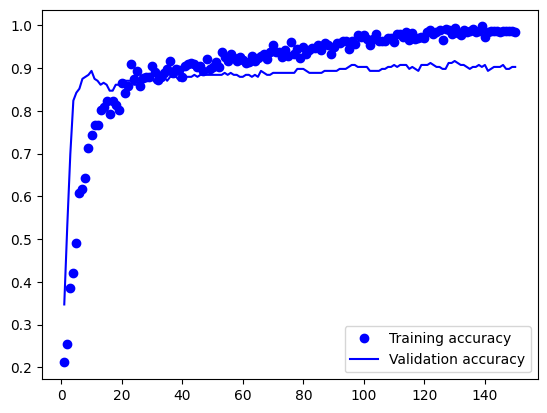

filepath after ['.data-00000-of-00001', 'checkpoint', '.index']
filepath after <tensorflow.python.training.tracking.util.CheckpointLoadStatus object at 0x7fab19d15ac0>
7/7 [==============================] - 0s 6ms/step - loss: 0.4529 - accuracy: 0.9167
Test accuracy: 91.67%
TOTAL TIME:  0.3385152816772461


In [ ]:
trained_model, predictions= run_experiment(X_train1, y_train_arr1, X_test1, y_test_arr1)


In [ ]:
trained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None)]      0         
                                                                 
 positional_embedding (Posit  (None, None, 150)        4200      
 ionalEmbedding)                                                 
                                                                 
 dropout (Dropout)           (None, None, 150)         0         
                                                                 
 encoder (Encoder)           (None, None, 150)         1449610   
                                                                 
 dropout_5 (Dropout)         (None, None, 150)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 150)              0         
 lMaxPooling1D)                                              

In [ ]:
import pickle
with open("/content/drive/MyDrive/HRNET/Train_cut", "rb") as fp:   # Unpickling
  train = pickle.load(fp)

with open("/content/drive/MyDrive/HRNET/Val_cut", "rb") as fp:   # Unpickling
  val = pickle.load(fp)

with open("/content/drive/MyDrive/HRNET/Test_cut", "rb") as fp:   # Unpickling
  test = pickle.load(fp)

In [ ]:
train_videos = pickle.load(open("/content/drive/My Drive/KTH_Private/train.p", "rb"))
valid_videos = pickle.load(open("/content/drive/My Drive/KTH_Private/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/KTH_Private/test.p", "rb"))

In [ ]:
train_labels = []
for video in train_videos:
  train_labels.append(video['category'])
print(len(train_labels))
# train = train_poses


val_labels = []
for video in valid_videos:
  val_labels.append(video['category'])
print(len(val_labels))
# val = val_poses

test_labels = []
for video in test_videos:
  test_labels.append(video['category'])
print(len(test_labels))

191
192
216


In [ ]:
train_labels = new_train_labels
test_labels = new_test_labels

In [ ]:
import numpy as np
import torch

# Example list of numpy arrays representing video frames
video_frames_list = train  # Replace with your own list of numpy arrays
# Example list of labels
labels_list = train_labels  # Replace with your own list of labels

# Convert list of video frames into a single numpy array
x_np = np.concatenate(video_frames_list, axis=0)  # Shape: (total_frames, 17, 2)

# Convert numpy array into PyTorch tensor
x_train = torch.from_numpy(x_np)  # Shape: (total_frames, 17, 2)

# Convert list of labels into a single numpy array
y_np = np.array(labels_list)  # Shape: (total_videos,)

# Convert numpy array into PyTorch tensor
y_train = torch.from_numpy(y_np)  #

In [ ]:
import numpy as np
import torch

# Example list of numpy arrays representing video frames
video_frames_list = test  # Replace with your own list of numpy arrays
# Example list of labels
labels_list = test_labels  # Replace with your own list of labels

# Convert list of video frames into a single numpy array
x_np = np.concatenate(video_frames_list, axis=0)  # Shape: (total_frames, 17, 2)

# Convert numpy array into PyTorch tensor
x_test = torch.from_numpy(x_np)  # Shape: (total_frames, 17, 2)

# Convert list of labels into a single numpy array
y_np = np.array(labels_list)  # Shape: (total_videos,)

# Convert numpy array into PyTorch tensor
y_test = torch.from_numpy(y_np)  #

In [ ]:
x_train.shape

torch.Size([7555, 17, 2])

In [ ]:
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, input_dim, max_frames, dropout_rate=0.1):
        super(PositionalEncoding, self).__init__()
        self.input_dim = input_dim
        self.max_frames = max_frames
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        self.pos_enc = self.add_weight(shape=(self.max_frames, self.input_dim),
                                       initializer=tf.keras.initializers.RandomNormal(),
                                       trainable=True)

    def call(self, x):
        pos_enc = self.pos_enc[0:x.shape[1], :]
        x = x + pos_enc
        return x

class TransformerModel(tf.keras.Model):
    def __init__(self, input_dim, num_frames, d_model, num_heads, dff, output_dim, max_positional_encoding=1000, dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.num_frames = num_frames
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.output_dim = output_dim
        self.max_positional_encoding = max_positional_encoding
        self.dropout_rate = dropout_rate

        self.pos_enc_layer = PositionalEncoding(input_dim=self.input_dim, max_frames=self.max_positional_encoding, dropout_rate=self.dropout_rate)
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(self.d_model, activation='relu')
        self.transformer_block = TransformerBlock(d_model=self.d_model, num_heads=self.num_heads, dff=self.dff, dropout_rate=self.dropout_rate)
        self.fc2 = tf.keras.layers.Dense(self.output_dim)

    def call(self, x):
        x = self.pos_enc_layer(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.transformer_block(x)
        x = self.fc2(x)
        return x

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs):
        attn_output = self.mha(inputs, inputs)
        attn_output = self.dropout(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load and preprocess data
# Assuming you have separate lists of numpy arrays for x and y, where each array represents a video
# x_videos_data = np.concatenate(x_train, x_test) # Replace with your own list of numpy arrays for x
# y_videos_data = [...]  # Replace with your own list of numpy arrays for y
# x_train, x_test, y_train, y_test = train_test_split(x_videos_data, y_videos_data, test_size=0.2, random_state=42)  # Split data into train and test sets
# Define positional encoding layer
import numpy as np
import tensorflow as tf

# Define your data


# Convert your data into TensorFlow tensors
x_train = [tf.constant(video, dtype=tf.float32) for video in x_train]
y_train = [tf.constant(label, dtype=tf.float32) for label in y_train]

# Define the Transformer model
class TransformerModel(tf.keras.Model):
    def __init__(self, input_dim, num_frames, d_model, num_heads, dff, output_dim, max_positional_encoding, dropout_rate):
        super(TransformerModel, self).__init__()
        self.pos_enc = self.positional_encoding(max_positional_encoding, d_model)
        self.d_model = d_model
        self.num_frames = num_frames
        self.transformer_block = self.transformer_block(d_model, num_heads, dff, dropout_rate)
        self.flatten = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(output_dim)

    def positional_encoding(self, position, d_model):
        angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
        angle_rads = np.arange(position)[:, np.newaxis] * angle_rates
        pos_enc = np.zeros((position, d_model), dtype=np.float32)
        pos_enc[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_enc[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(pos_enc, dtype=tf.float32)

    def transformer_block(self, d_model, num_heads, dff, dropout_rate):
        inputs = tf.keras.Input(shape=(self.num_frames, 17, 2))

        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

        # Multi-head self-attention
        attn_output = tf.keras.layers.MultiHeadAttention(
            key_dim=d_model, num_heads=num_heads, dropout=dropout_rate
        )(x, x)
        x = tf.keras.layers.Add()([x, attn_output])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

        # Point-wise feed forward networks
        ffn_output = tf.keras.layers.Conv1D(filters=dff, kernel_size=1, activation="relu")(x)
        ffn_output = tf.keras.layers.Conv1D(filters=d_model, kernel_size=1)(ffn_output)
        x = tf.keras.layers.Add()([x, ffn_output])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

        return tf.keras.Model(inputs=inputs, outputs=x)

    def call(self, x):
        # Add positional encoding
        pos_enc = self.pos_enc[tf.newaxis, : self.num_frames, :, :]
        x = x + pos_enc

        # Reshape and pass through transformer block
        x = self.flatten(x)
        x = self.transformer_block(x)
        x = self.fc(x)

        return x

# Create Transformer model instance
input_dim = 2
num_frames = 7
d_model = 2
num_heads = 4
dff = 256
output_dim = 10
max_positional_encoding = 1000
dropout_rate = 0.1

model = TransformerModel(
    input_dim=input_dim,
    num_frames=num_frames,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    output_dim=output_dim,
    max_positional_encoding=max_positional_encoding,
    dropout_rate=dropout_rate
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_object = tf.keras.losses.MeanSquaredError()
metric = tf.keras.metrics.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss_object, metrics=[metric])

max_frames = max([video.shape[0] for video in x_train])

# Pad the videos to the maximum number of frames
x_train_padded = []
for video in x_train:
    padding = max_frames - video.shape[0]
    padded_video = np.pad(video, ((0, padding), (0, 0), (0, 0)), mode='constant')
    x_train_padded.append(padded_video)
x_train_padded = np.array(x_train_padded)

# Convert x_train_padded and y_train to TensorFlow datasets
x_train_dataset = tf.data.Dataset.from_tensor_slices(x_train_padded)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)

# Zip the x_train_padded and y_train datasets together
train_dataset = tf.data.Dataset.zip((x_train_dataset, y_train_dataset))

# Shuffle and batch the train_dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(x_train_padded)).batch(batch_size)

# Train the model
batch_size = 32  # Replace with your desired batch size
epochs = 10  # Replace with your desired number of epochs
history = model.fit(train_dataset, epochs=epochs)




Epoch 1/10


ValueError: ignored

In [ ]:
for a in x_test:
  print(a.shape[0])

36
35
47
31
33
48
39
38
35
47
45
42
39
48
50
42
37
41
47
47
40
50
45
37
37
43
39
39
40
46
48
46
38
48
43
39
40
46
39
42
42
41
46
39
43
43
51
49
50
56
43
51
44
46
49
45
38
39
41
35
42
49
44
50
47
41
46
49
61
57
54
46
66
57
64
60
54
51
51
51
61
67
54
55
58
50
49
53
59
51
52
53
48
49
51
48
21
29
20
28
22
40
21
28
25
39
22
28
23
36
19
26
19
39
18
28
20
46
19
26
23
43
24
33
22
38
24
27
15
22
15
19
16
27
15
21
18
29
17
22
13
23
14
19
15
30
15
20
12
28
13
18
14
33
17
23
17
30
19
22
30
49
33
46
36
63
33
38
36
58
34
48
39
62
31
42
34
63
29
48
37
75
33
39
31
70
32
36
40
66
43
43


AttributeError: ignored

In [ ]:
x_train = train
x_test = val

Epoch 1/30
121/124 [============================>.] - ETA: 0s - loss: 2.0301 - accuracy: 0.4712
Epoch 1: val_accuracy improved from -inf to 0.54815, saving model to /tmp/video_classifier/
124/124 [==============================] - 4s 17ms/step - loss: 2.0080 - accuracy: 0.4771 - val_loss: 1.4639 - val_accuracy: 0.5481
Epoch 2/30
121/124 [============================>.] - ETA: 0s - loss: 0.8034 - accuracy: 0.7774
Epoch 2: val_accuracy improved from 0.54815 to 0.59630, saving model to /tmp/video_classifier/
124/124 [==============================] - 2s 14ms/step - loss: 0.8015 - accuracy: 0.7786 - val_loss: 1.3246 - val_accuracy: 0.5963
Epoch 3/30
121/124 [============================>.] - ETA: 0s - loss: 0.5663 - accuracy: 0.8503
Epoch 3: val_accuracy improved from 0.59630 to 0.60370, saving model to /tmp/video_classifier/
124/124 [==============================] - 2s 14ms/step - loss: 0.5654 - accuracy: 0.8503 - val_loss: 1.3032 - val_accuracy: 0.6037
Epoch 4/30
121/124 [==============

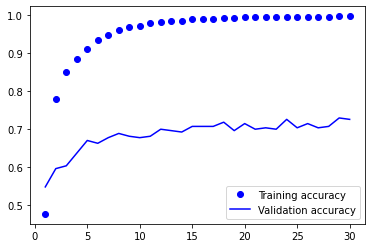

filepath after ['checkpoint', '.data-00000-of-00001', '.index']
filepath after <tensorflow.python.training.tracking.util.CheckpointLoadStatus object at 0x7fba12dcc210>
9/9 [==============================] - 0s 5ms/step - loss: 1.4012 - accuracy: 0.7296
Test accuracy: 72.96%
TOTAL TIME:  0.3048262596130371


In [ ]:
trained_model, predictions= run_experiment(X_train2, y_train_arr2, X_test2, y_test_arr2)


Epoch 1/30
121/125 [============================>.] - ETA: 0s - loss: 2.2705 - accuracy: 0.4400
Epoch 1: val_accuracy improved from -inf to 0.52075, saving model to /tmp/video_classifier/
125/125 [==============================] - 4s 17ms/step - loss: 2.2388 - accuracy: 0.4472 - val_loss: 1.6227 - val_accuracy: 0.5208
Epoch 2/30
121/125 [============================>.] - ETA: 0s - loss: 0.8077 - accuracy: 0.7856
Epoch 2: val_accuracy improved from 0.52075 to 0.59245, saving model to /tmp/video_classifier/
125/125 [==============================] - 2s 15ms/step - loss: 0.8060 - accuracy: 0.7852 - val_loss: 1.4039 - val_accuracy: 0.5925
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.8522
Epoch 3: val_accuracy improved from 0.59245 to 0.60755, saving model to /tmp/video_classifier/
125/125 [==============================] - 2s 15ms/step - loss: 0.5557 - accuracy: 0.8522 - val_loss: 1.2915 - val_accuracy: 0.6075
Epoch 4/30
121/125 [==============

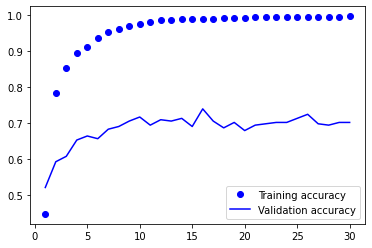

filepath after ['checkpoint', '.data-00000-of-00001', '.index']
filepath after <tensorflow.python.training.tracking.util.CheckpointLoadStatus object at 0x7fba14135150>
9/9 [==============================] - 0s 5ms/step - loss: 1.2448 - accuracy: 0.7396
Test accuracy: 73.96%
TOTAL TIME:  0.303314208984375


In [ ]:
trained_model, predictions= run_experiment(X_train3, y_train_arr3, X_test3, y_test_arr3)


In [ ]:
trained_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None)]      0         
                                                                 
 positional_embedding_2 (Pos  (None, None, 150)        4200      
 itionalEmbedding)                                               
                                                                 
 dropout_10 (Dropout)        (None, None, 150)         0         
                                                                 
 encoder_2 (Encoder)         (None, None, 150)         1449610   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 150)              0         
 balMaxPooling1D)                                                
                                                                 
 flatten_2 (Flatten)         (None, 150)               0   

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test_arr1, y_pred1.argmax(axis=1))


NameError: ignored

In [ ]:
#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(21)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()